In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from pathlib import Path
from disparity.methods import Calibration, InputPair, Config
from disparity.method_cre_stereo import CREStereo
from ipywidgets import interact, fixed, IntSlider, Checkbox
# Instalamos el paquete de utilidades
%pip install -qq git+https://github.com/udesa-vision/i308-utils.git

from i308_utils import imshow, show_images
from utils import rect_maps, rectify_stereo_pair, compare_rectified_imgs, draw_epipolar_lines, show_pair_any, compute_depth

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Cargamos los datos de calibración y calculamos los mapas de rectificación
with open('./code_examples/charuco_example/res/stereo_calibration.pkl', 'rb') as f:
    calib = pickle.load(f)

rect_maps, rect_data = rect_maps(calib)

print("Keys in calibration data:", calib.keys())
print("Keys in rectification maps:", rect_maps.keys())
print("Keys in rectification data:", rect_data.keys())

Keys in calibration data: dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])
Keys in rectification maps: dict_keys(['left_map_x', 'left_map_y', 'right_map_x', 'right_map_y'])
Keys in rectification data: dict_keys(['R1', 'R2', 'P1', 'P2', 'Q'])


Pares rectificados: 20


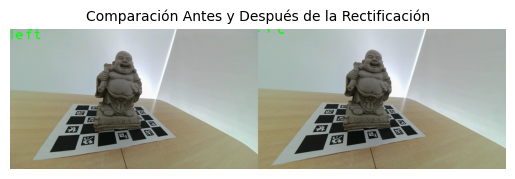

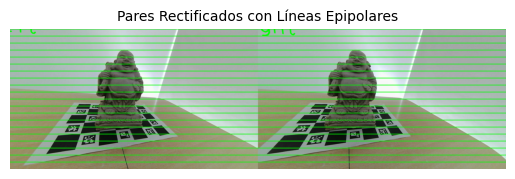

In [5]:
# Rectificamos los pares estéreo
in_dir = Path('datasets/stereo_budha_charuco/captures')
out_dir = Path('datasets/stereo_budha_charuco/rectified')
out_dir.mkdir(exist_ok=True)

indices = list(range(0, 20))
processed_pairs = 0
missing_pairs = []

for i in indices:
    left_path = in_dir / f'left_{i}.jpg'
    right_path = in_dir / f'right_{i}.jpg'

    if not left_path.exists() or not right_path.exists():
        missing_pairs.append(i)
        continue

    rectL, rectR = rectify_stereo_pair(str(left_path), str(right_path), rect_maps)

    # Guardamos las imágenes rectificadas
    cv2.imwrite(str(out_dir / f'rect_left_{i}.jpg'), rectL)
    cv2.imwrite(str(out_dir / f'rect_right_{i}.jpg'), rectR)
    processed_pairs += 1

print(f'Pares rectificados: {processed_pairs}')
if missing_pairs:
    print(f'Pares faltantes: {missing_pairs}')

# Mostramos un par rectificado de ejemplo
comparison = np.hstack([cv2.imread(left_path), rectL])
imshow(comparison, title='Comparación Antes y Después de la Rectificación')

# Mostramos un par rectificado de ejemplo con líneas epipolares
pair_ep_lines = draw_epipolar_lines(rectL, rectR)
imshow(pair_ep_lines, title='Pares Rectificados con Líneas Epipolares')

## Cálculo de Disparidad

## CREStereo

In [8]:
# Convertimos las imágenes a escala de grises
grayL = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)

w, h = grayL.shape[1], grayL.shape[0]

fx = calib['left_K'][0][0]
fy = calib['left_K'][1][1]
cx0 = calib['left_K'][0][2]
cy0 = calib['left_K'][1][2]
baseline = np.linalg.norm(calib['T'])

# Carpeta de salida
out_dir = Path('./out/disparities_cre_stereo')
out_dir.mkdir(parents=True, exist_ok=True)

# Configuración del método CREStereo
models_path = Path("models")
models_path.mkdir(exist_ok=True)

config = Config(models_path=models_path)
cre_stereo = CREStereo(config)

cre_stereo.parameters['Shape'].set_value('1280x720')
indices = range(10, 15)  # Procesamos un subconjunto de imágenes para el ejemplo

disparity_maps = []

for i in indices:
    left_path = in_dir / f'left_{i}.jpg'
    right_path = in_dir / f'right_{i}.jpg'

    if not left_path.exists() or not right_path.exists():
        print(f'Saltando par {i}, faltan imágenes.')
        continue

    # Rectificamos las imágenes
    rectL, rectR = rectify_stereo_pair(str(left_path), str(right_path), rect_maps)
    rectL_gray = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY)
    rectR_gray = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)

    # Calibración e input para CREStereo
    calibration = Calibration(**{
        "width": w,
        "height": h,
        "baseline_meters": baseline / 1000,
        "fx": fx,
        "fy": fy,
        "cx0": cx0,
        "cx1": cx0,
        "cy": cy0,
        "depth_range": [0.05, 20.0],
        "left_image_rect_normalized": [0, 0, 1, 1]
    })

    input_pair = InputPair(
        left_image=rectL_gray,
        right_image=rectR_gray,
        calibration=calibration
    )

    # Computamos el mapa de disparidad con CREStereo
    disparity_cre = cre_stereo.compute_disparity(input_pair)
    disparity_cre_px = disparity_cre.disparity_pixels.astype(np.float32)
    disparity_maps.append(disparity_cre_px)

models\crestereo_combined_iter5_720x1280.onnx
models\crestereo_combined_iter5_720x1280.onnx
models\crestereo_combined_iter5_720x1280.onnx
models\crestereo_combined_iter5_720x1280.onnx
models\crestereo_combined_iter5_720x1280.onnx
